Correct for dust extinction due to both Galactic dust and the extinction within the galaxy (should be a function of inclination).

In [1]:
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import time

import matplotlib.pyplot as plt

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Data

## Galaxies

In [3]:
gals_directory = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/'

gals_filename = 'SGA-2020_fuji_Vrot_phot-K-Corr.fits'

gals = Table.read(gals_directory + gals_filename)

In [4]:
targets_directory = '/global/cfs/projectdirs/desi/science/td/pv/'

targets_filename = 'desi_pv_tf_fuji_healpix.fits'

targets = Table.read(targets_directory + targets_filename)

In [5]:
fastspecfit_directory = '/global/cfs/cdirs/desi/public/edr/vac/edr/fastspecfit/fuji/v3.2/'

# Dust extinction

Ratios of total to selective extinction (rederived from Schlafly11 and listed on https://www.legacysurvey.org/dr10/catalogs/#galactic-extinction-coefficients)

In [6]:
Rr = 2.165
Rv = 3.1 # from Schlafly & Finkbeiner (2011) - https://ui.adsabs.harvard.edu/abs/2011ApJ...737..103S/abstract

## 1. Extract line fluxes

We need to identify which spectra were actually used in the analysis, so that we can use "good" flux estimates.

In [7]:
################################################################################
# Separate the data into center and off-center observations
#-------------------------------------------------------------------------------
targets['SKY_FIBER_DIST'] = 0.
targets['SKY_FIBER_DIST_R26'] = 0.
targets['V_ROT'] = np.nan
targets['V_ROT_ERR'] = np.nan


for i in range(len(gals)):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = targets['SGA_ID'] == gals['SGA_ID'][i]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the galaxy
    #---------------------------------------------------------------------------
    gal_coords = SkyCoord(ra=gals['RA'][i], 
                          dec=gals['DEC'][i], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=targets['RA'][obs_idx], 
                             dec=targets['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(gal_coords)
    
    targets['SKY_FIBER_DIST'][obs_idx] = sep2d
    targets['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(gals['D26'][i]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate the rotational velocity
    #---------------------------------------------------------------------------
    targets['V_ROT'][obs_idx] = c*(targets['Z'][obs_idx] - gals['Z_DESI'][i])
    targets['V_ROT_ERR'][obs_idx] = c*np.sqrt(targets['ZERR'][obs_idx]**2 + gals['ZERR_DESI'][i]**2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (gals['BA'][i]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
        
    targets['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------


centers_boolean = targets['SKY_FIBER_DIST_R26'] < 0.1

target_centers = targets[centers_boolean]
# target_axis = targets[~centers_boolean]
################################################################################


################################################################################
# Clean the center observations
#
# Only keep those with
#  - DELTACHI2 > 25
#  - ZWARN == 0
#-------------------------------------------------------------------------------
good_centers = target_centers[(target_centers['DELTACHI2'] > 25) & (target_centers['ZWARN'] == 0)]
################################################################################

'''
################################################################################
# Clean the axis observations
#
# Requirements:
#  - 10 < Vrot < 1000 km/s
#  - Delta V / Vmin <= 5
#-------------------------------------------------------------------------------
# Velocity cut
#-------------------------------------------------------------------------------
good_axis = target_axis[(np.abs(target_axis['V_ROT']) < 1000) & (np.abs(target_axis['V_ROT']) > 10)]
#-------------------------------------------------------------------------------
# Relative velocity cut
#-------------------------------------------------------------------------------
good_deltaV = np.ones(len(good_axis), dtype=bool)

for sga_id in gals['SGA_ID']:
    
    # Identify all axis targets on this galaxy
    obs_idx = good_axis['SGA_ID'] == sga_id
''';

In [13]:
gals['HaHb'] = np.nan
gals['HaHb_err'] = np.nan

rng = np.random.default_rng()
N_samples = 1000

for i in range(len(gals)):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_centers['SGA_ID'] == gals['SGA_ID'][i]
    
    # Identify targetIDs for galaxy
    targetids = good_centers['TARGETID'][obs_idx]
    
    # Identify filenames for galaxy
    filenames = good_centers['FILENAME'][obs_idx]
    
    # Initialize Ha, Hb arrays
    Ha = np.nan*np.ones(sum(obs_idx))
    Hb = np.nan*np.ones(sum(obs_idx))
    Ha_ivar = np.nan*np.ones(sum(obs_idx))
    Hb_ivar = np.nan*np.ones(sum(obs_idx))
    
    # Extract fluxes from fastspecfit catalog
    for j in range(len(filenames)):
        
        # Strip "fuji/" from filename
        rr_filename = filenames[j][5:]
        
        # Replace "redrock" with "fastspec"
        dirs, file = rr_filename.split('redrock')
        fs_filename = dirs + 'fastspec' + file + '.gz'
        
        # Open file
        hdul = fits.open(fastspecfit_directory + fs_filename, hdu=1)
        fs_file = hdul[1].data
        hdul.close()
        
        # Find row for this targetid
        targetid_idx = fs_file['TARGETID'] == targetids[j]
        
        if sum(targetid_idx) == 1:
            # Extract Ha, Hb fluxes
            Ha[j] = fs_file['HALPHA_FLUX'][targetid_idx]
            Hb[j] = fs_file['HBETA_FLUX'][targetid_idx]
            Ha_ivar[j] = fs_file['HALPHA_FLUX_IVAR'][targetid_idx]
            Hb_ivar[j] = fs_file['HBETA_FLUX_IVAR'][targetid_idx]
            
    if np.any((1/np.sqrt(Ha_ivar) > Ha) | (1/np.sqrt(Hb_ivar) > Hb)):
        print(targetids, Ha, 1/np.sqrt(Ha_ivar), Hb, 1/np.sqrt(Hb_ivar))
    
    # Compute average flux ratios
    gals['HaHb'][i] = np.nanmean(Ha/Hb)
    
    # Compute uncertainty in average flux ratio
    Ha_random = rng.normal(Ha, 1/np.sqrt(Ha_ivar), size=(N_samples, len(Ha)))
    Hb_random = rng.normal(Hb, 1/np.sqrt(Hb_ivar), size=(N_samples, len(Hb)))
    HaHb_random = Ha_random/Hb_random
    gals['HaHb_err'][i] = np.nanstd(HaHb_random)

     TARGETID    
-----------------
39627817951955633 [7.79920435] [1.2660279] [1.36633444] [2.11619078]
     TARGETID    
-----------------
39628465175004507 [0.11106434] [9.51409128] [35.67062759] [11.1972553]


/tmp/ipykernel_852492/1027776735.py:49: RuntimeWarning: divide by zero encountered in true_divide
  if np.any((1/np.sqrt(Ha_ivar) > Ha) | (1/np.sqrt(Hb_ivar) > Hb)):
/tmp/ipykernel_852492/1027776735.py:50: RuntimeWarning: divide by zero encountered in true_divide
  print(targetids, Ha, 1/np.sqrt(Ha_ivar), Hb, 1/np.sqrt(Hb_ivar))
/tmp/ipykernel_852492/1027776735.py:53: RuntimeWarning: divide by zero encountered in true_divide
  gals['HaHb'][i] = np.nanmean(Ha/Hb)
/tmp/ipykernel_852492/1027776735.py:57: RuntimeWarning: divide by zero encountered in true_divide
  Hb_random = rng.normal(Hb, 1/np.sqrt(Hb_ivar), size=(N_samples, len(Hb)))


     TARGETID    
-----------------
39632991248449659 [28.41849518] [2.49223767] [0.] [inf]
     TARGETID    
-----------------
39628438633448398 [0.] [inf] [2.2521143] [4.2700493]


/tmp/ipykernel_852492/1027776735.py:56: RuntimeWarning: divide by zero encountered in true_divide
  Ha_random = rng.normal(Ha, 1/np.sqrt(Ha_ivar), size=(N_samples, len(Ha)))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


     TARGETID    
-----------------
39633114233834138 [0.] [inf] [6.12614679] [6.12837094]
     TARGETID    
-----------------
39633315468150062 [9.61582947] [1.55762507] [0.] [inf]
     TARGETID    
-----------------
39627914970401768 [0.] [inf] [7.33205128] [4.92694884]
     TARGETID    
-----------------
39627799807394778
39627799807394778 [ 9.0328846  11.65234566] [0.38997697 1.12200024] [2.71799755 0.        ] [0.77878126        inf]
     TARGETID    
-----------------
39627776289934029 [38.70440674] [3.3246307] [1.64622951] [2.2143936]
      TARGETID     
-------------------
  39628433264739253
2305843020118892462
  39628433264739253 [0. 0. 0.] [inf inf inf] [0. 0. 0.] [inf inf inf]


/tmp/ipykernel_852492/1027776735.py:53: RuntimeWarning: invalid value encountered in true_divide
  gals['HaHb'][i] = np.nanmean(Ha/Hb)
/tmp/ipykernel_852492/1027776735.py:53: RuntimeWarning: Mean of empty slice
  gals['HaHb'][i] = np.nanmean(Ha/Hb)
/tmp/ipykernel_852492/1027776735.py:58: RuntimeWarning: invalid value encountered in true_divide
  HaHb_random = Ha_random/Hb_random
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


     TARGETID    
-----------------
39627782275203522 [7.14422464] [0.78951705] [5.73038342e-05] [1.45646072]
     TARGETID    
-----------------
39633421919586900 [10.77036667] [1.30885755] [1.82468784] [2.11638561]
     TARGETID    
-----------------
39633443776106994 [23.17792702] [2.00716224] [1.7996248] [2.70519337]
     TARGETID    
-----------------
39627770195607790 [25.76053429] [1.68616213] [0.] [inf]
     TARGETID    
-----------------
39628427912810105 [0.] [inf] [8.37655926] [4.49568461]
     TARGETID    
-----------------
39628368169144466 [8.39901733] [2.90883818] [0.] [inf]
     TARGETID    
-----------------
39627817947761397 [20.79677963] [3.11923754] [2.91558504] [4.13390089]
     TARGETID    
-----------------
39628433264741476 [0.] [inf] [0.] [inf]
     TARGETID    
-----------------
39628427896034511 [0.] [inf] [9.81221581] [5.2374478]
     TARGETID    
-----------------
39628433256351023 [0.] [inf] [0.] [inf]
     TARGETID    
-----------------
39628433289907237 

KeyboardInterrupt: 

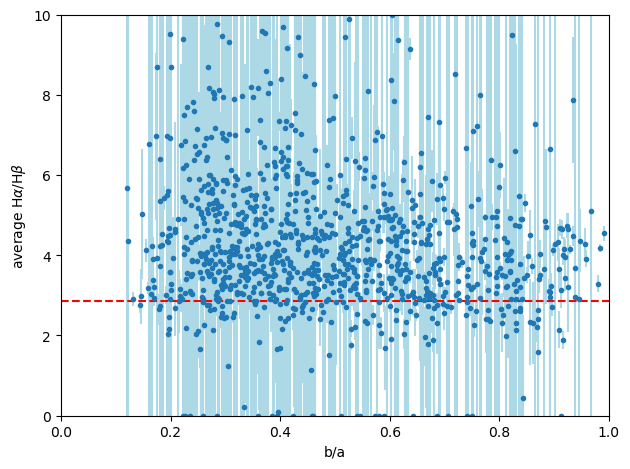

In [11]:
plt.figure(tight_layout=True)

plt.errorbar(gals['BA'], gals['HaHb'], yerr=gals['HaHb_err'], fmt='.', ecolor='lightblue')
# plt.plot(gals['BA'], gals['HaHb'], '.')
plt.hlines(2.86, 0, 1, colors='r', linestyles='dashed')
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.xlabel('b/a')
plt.ylabel(r'average H$\alpha$/H$\beta$');

## 2. Compute $E(B-V)$ value for each galaxy

$A_\lambda / A_V$ from [O'Donnell (1994)](https://ui.adsabs.harvard.edu/abs/1994ApJ...422..158O/abstract)

In [10]:
def ODon94(wave, Rv):
    '''
    Calculate the interstellar extinction, A(lambda)/Av, using the extinction curve defined in O'Donnell (1994).
    
    
    PARAMETERS
    ==========
    
    wave : float
        Wavelength for which the extinction should be calculated.  Units are Angstroms.
        
    Rv : float
        Extinction ratio
        
        
    RETURNS
    =======
    
    AwAv : float
        The interstellar extinction for the given wavelength.
    '''
    
    # Convert wavelength to microns
    wave_um = wave/1e4
    
    # Calculate inverse wavelength
    x = 1/wave_um
    
    # Calculate wavelength shift
    y = x - 1.82
    
    # Calculate coefficients
    a = 1 + 0.104*y - 0.609*y**2 + 0.701*y**3 + 1.137*y**4 - 1.718*y**5 - 0.827*y**6 + 1.647*y**7 - 0.505*y**8
    b = 1.952*y + 2.908*y**2 - 3.989*y**3 - 7.985*y**4 + 11.102*y**5 + 5.491*y**6 - 10.805*y**7 + 3.347*y**8
    
    # Calculate extinction
    AwAv = a + b/Rv
    
    return AwAv

In [11]:
AHaAv = ODon94(6563, Rv)
AHbAv = ODon94(4861, Rv)

gals['EBV'] = 2.5*np.log10(2.86/gals['HaHb'])/(Rv*(AHaAv - AHbAv))

HaHb_random = rng.normal(gals['HaHb'], gals['HaHb_err'], size=(N_samples, len(gals)))
gals['EBV_ERR'] = np.nanstd(HaHb_random, axis=0)

/tmp/ipykernel_1779369/1304718783.py:4: RuntimeWarning: divide by zero encountered in true_divide
  gals['EBV'] = 2.5*np.log10(2.86/gals['HaHb'])/(Rv*(AHaAv - AHbAv))
/tmp/ipykernel_1779369/1304718783.py:4: RuntimeWarning: divide by zero encountered in log10
  gals['EBV'] = 2.5*np.log10(2.86/gals['HaHb'])/(Rv*(AHaAv - AHbAv))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


## 3. Compute dust extinction correction

\begin{equation}
  A_\text{dust} = R_r E(B - V)
\end{equation}

In [12]:
gals['Adust'] = Rr * gals['EBV']
gals['Adust_err'] = Rr * gals['EBV_ERR']

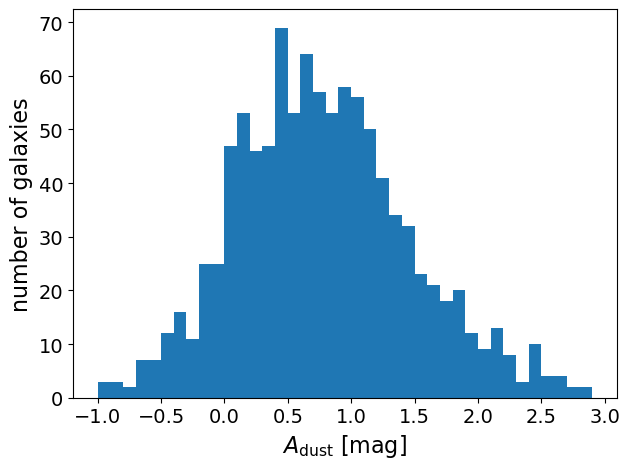

In [13]:
plt.figure(tight_layout=True)

plt.hist(gals['Adust'], bins=np.arange(-1, 3, 0.1))

plt.xlabel(r'$A_\text{dust}$ [mag]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14);

# plt.savefig('../Figures/SV/fuji_Adust_hist_20240701.png', dpi=150);

## 4. Apply dust correction

In [14]:
if 'R_MAG_SB26_CORR' not in gals.colnames:    
    gals['R_MAG_SB26_CORR'] = gals['R_MAG_SB26']
    gals['R_MAG_SB26_CORR_ERR'] = gals['R_MAG_SB26_ERR']

# Only adjust those galaxies which have valid corrections
nan_gal = np.isnan(gals['Adust'])
    
gals['R_MAG_SB26_CORR'][~nan_gal] -= gals['Adust'][~nan_gal]
gals['R_MAG_SB26_CORR_ERR'][~nan_gal] = np.sqrt(gals['R_MAG_SB26_CORR_ERR'][~nan_gal]**2 + gals['Adust_err'][~nan_gal]**2)

# Save results to file

In [15]:
gals.write(gals_directory + 'SGA-2020_fuji_Vrot_phot-K-dust-Corr.fits', overwrite=True)